### S2 Geometry

Official website: http://s2geometry.io/

Original GitHub repo with instructions how to install the library: https://github.com/google/s2geometry

After setting it up, you should be able to install s2_py with `pip install s2-py`

In [1]:
import s2_py as s2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp
import geopandas as gpd
from shapely.geometry import Polygon, mapping

## California in S2 Cells

### Getting CA coordinates

In [17]:
# For S2 Loop coordinates need to be in CCW direction
ca_coord = pd.read_csv('./Data/CA_coord_ccw.txt', header=None, delim_whitespace=True)
ca_coord.columns = ['lat', 'long']
ca_coord.head()

,lat,long
0,41.9983,-124.40
1,41.7170,-124.45
2,41.2386,-124.34
3,41.0110,-124.31
4,40.4658,-124.65


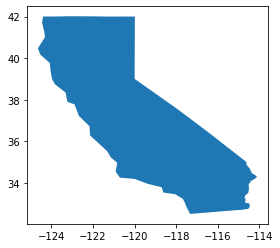

In [18]:
ca_polygon = Polygon(zip(ca_coord.long, ca_coord.lat))
crs = {'init': 'epsg:4326'}
ca_polygon2 = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[ca_polygon])  
ca_polygon2.plot()

In [19]:
ca_lats = ca_coord.lat.tolist()
ca_longs = ca_coord.long.tolist()

points = []
for i in range(len(ca_lats)):
    latlng = s2.S2LatLng.FromDegrees(ca_lats[i], ca_longs[i])
    points.append(latlng.ToPoint())
loop = s2.S2Loop(points)

S2 Cells sizes: http://s2geometry.io/resources/s2cell_statistics

In [20]:
coverer = s2.S2RegionCoverer()
coverer.set_min_level(12)
coverer.set_max_level(12)
# coverer.set_max_cells(500)
covering = coverer.GetCovering(loop)

In [21]:
type(covering), len(covering)

(tuple, 100076)

## Mapping CA and S2 Cells

Source: https://www.census.gov/cgi-bin/geo/shapefiles/index.php

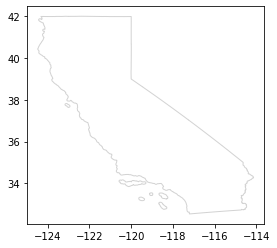

In [9]:
ca_df = gpd.read_file("./Data/CA_State/CA_State_TIGER2016.shp")
ca_df = ca_df.to_crs({'init': 'epsg:4326'})
ca_df.plot(color='white', edgecolor='lightgrey')

In [10]:
ca_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,4,9,06,01779778,06,CA,California,00,G4000,A,403501101370,20466718403,+37.1551773,-119.5434183,(POLYGON ((-119.6347313537315 33.2654466936341...


In [22]:
geoms = []
for cellid in covering:
    new_cell = s2.S2Cell(cellid)
    vertices = []
    for i in range(4):
        vertex = new_cell.GetVertex(i)
        latlng = s2.S2LatLng(vertex)
        vertices.append((latlng.lng().degrees(),
                         latlng.lat().degrees()))
    geo = Polygon(vertices)
    geoms.append(geo)

In [23]:
len(geoms)

100076

In [24]:
geoms_df = gpd.GeoDataFrame(crs=crs, geometry=geoms)  
geoms_df.shape

(100076, 1)

In [25]:
geoms_df.head()

,geometry
0,"POLYGON ((-121.4742601200827 42.0211361095208,..."
1,"POLYGON ((-121.538901534136 42.02063732859841,..."
2,POLYGON ((-121.5216871390368 42.00668446866296...
3,POLYGON ((-121.4979761458602 42.01391278357534...
4,POLYGON ((-121.4807815669189 41.99995397496993...


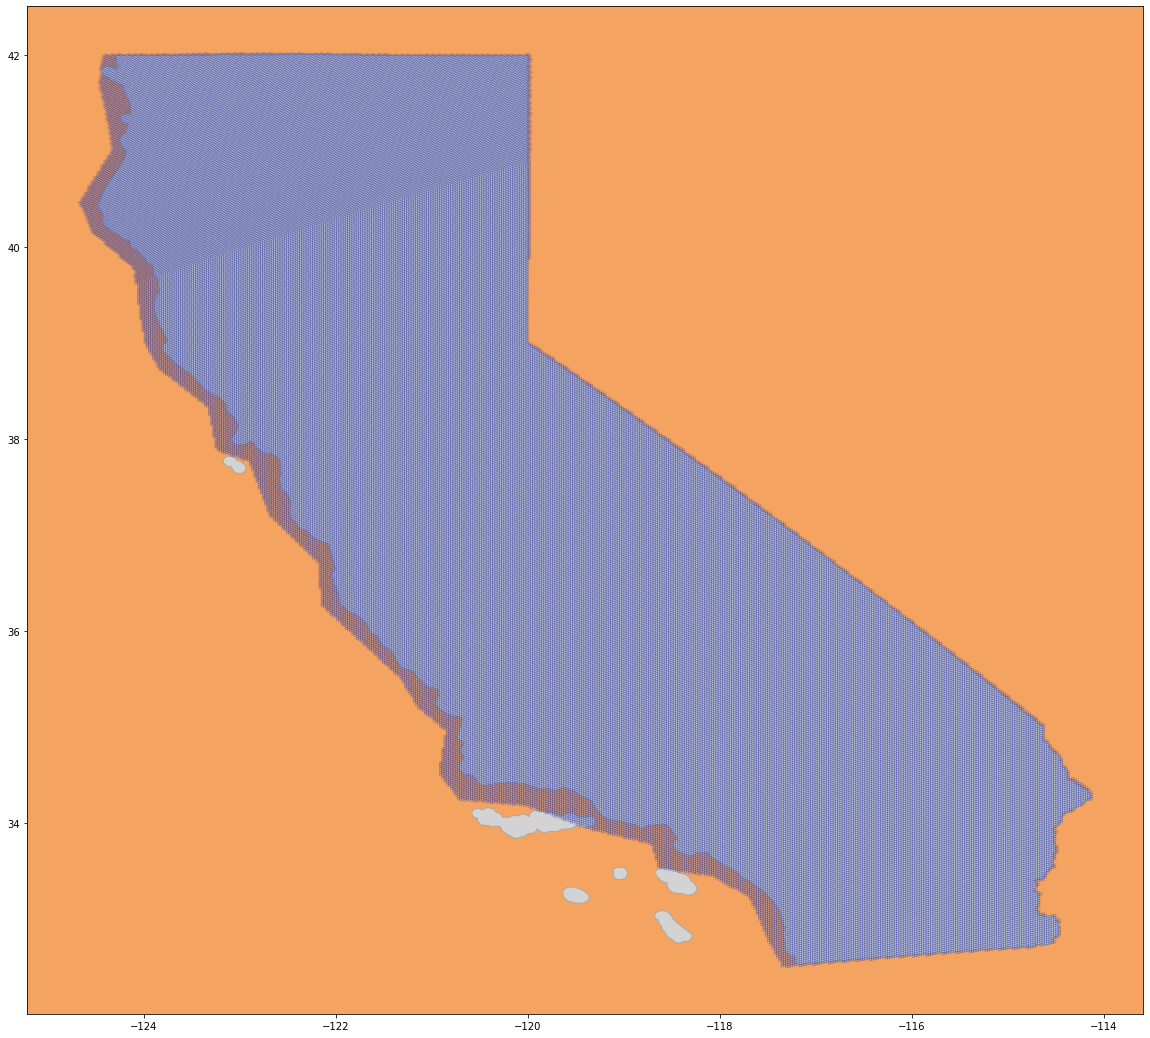

In [27]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
geoms_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
plt.show()

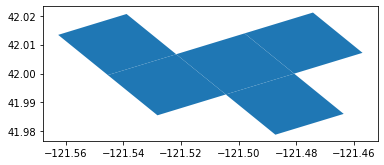

In [26]:
geoms_df.head().plot()

### Wildfire Perimeters Data

Source: http://frap.fire.ca.gov/data/frapgisdata-sw-fireperimeters_download

Data Description: http://frap.fire.ca.gov/projects/fire_data/fire_perimeters_data_description

Incident data: http://cdfdata.fire.ca.gov/incidents/incidents_archived

In [2]:
cal_fire_hist_df = gpd.read_file("./Data/fire18_1.gdb", layer=1)
cal_fire_hist_df.shape

(20508, 18)

In [3]:
cal_fire_hist_df = cal_fire_hist_df.to_crs({'init': 'epsg:4326'})
cal_fire_hist_df.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry
0,2007,CA,CCO,LAC,OCTOBER,00246393,2007-10-21T00:00:00,2007-10-23T00:00:00,14.0,,NaN,25.736713,8.0,1.0,00233414,1902.439051,1.041528e+05,(POLYGON ((-118.4985124819225 34.3824189370446...
1,2007,CA,CCO,LAC,MAGIC,00233077,2007-10-22T00:00:00,2007-10-25T00:00:00,14.0,,NaN,2824.877197,8.0,1.0,00233077,20407.965662,1.143187e+07,(POLYGON ((-118.5844782794717 34.4197766738174...
2,2007,CA,USF,ANF,RANCH,00000166,2007-10-20T00:00:00,2007-11-15T00:00:00,2.0,,54716.0,58410.335938,7.0,1.0,00000166,169150.715690,2.363782e+08,(POLYGON ((-118.7564468802518 34.5965130520924...
3,2007,CA,CCO,LAC,EMMA,00201384,2007-09-11T00:00:00,2007-09-11T00:00:00,14.0,,NaN,172.214951,8.0,1.0,00201384,6117.777086,6.969292e+05,(POLYGON ((-118.0727716195954 34.5019812566583...
4,2007,CA,CCO,LAC,CORRAL,00259483,2007-11-24T00:00:00,2007-11-27T00:00:00,14.0,,NaN,4707.997070,8.0,1.0,00259483,22907.182174,1.905259e+07,(POLYGON ((-118.7440804532698 34.0812976688129...


In [32]:
cal_fire_hist_df.YEAR_.nunique()

122

In [5]:
cal_fire_hist_df['YEAR'] = pd.to_numeric(cal_fire_hist_df.YEAR_)

In [38]:
cal_fire_hist_df[cal_fire_hist_df.YEAR >= 2000].YEAR.value_counts().sort_index()

2000.0    191
2001.0    207
2002.0    243
2003.0    341
2004.0    277
2005.0    306
2006.0    315
2007.0    349
2008.0    438
2009.0    254
2010.0    209
2011.0    317
2012.0    351
2013.0    298
2014.0    238
2015.0    318
2016.0    352
2017.0    607
2018.0    413
Name: YEAR, dtype: int64

In [6]:
cal_fire_hist_df[cal_fire_hist_df.YEAR >= 2000].shape

(6024, 19)

In [46]:
cal_fire_hist_df.YEAR.min()

1878.0

In [44]:
cal_fire_hist_df.sort_values(by='GIS_ACRES', ascending=False).head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,YEAR
10194,2002,CA,USF,PNF,BISCUIT,00000000,2002-07-13T00:00:00,2002-11-08T00:00:00,1.0,,499945.0,501082.03125,8.0,1.0,00000003,403257.735458,2.027807e+09,(POLYGON ((-123.7943933086646 42.6073588798078...,2002.0
20347,2018,CA,CDF,LNU,RANCH,00008646,2018-07-27T00:00:00,2018-09-19T00:00:00,14.0,MENDOCINO_COMPLEX,410203.0,410202.46875,7.0,1.0,None,348227.665079,1.660030e+09,(POLYGON ((-122.7106315635918 39.0461837853999...,2018.0
17382,2012,CA,BLM,NOD,RUSH,00003490,2012-08-12T00:00:00,2012-10-22T00:00:00,1.0,,315577.0,315511.50000,3.0,1.0,None,414346.362960,1.276830e+09,(POLYGON ((-119.9160253635005 40.9232601957361...,2012.0
19929,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04T00:00:00,2018-01-12T00:00:00,9.0,CONT_DATE based on Inciweb,281893.0,281790.87500,7.0,1.0,None,445282.444798,1.140367e+09,(POLYGON ((-119.6204504308018 34.4438152012489...,2017.0
15180,2003,CA,USF,CNF,CEDAR,00000000,2003-10-25T00:00:00,2003-11-05T00:00:00,2.0,,280278.0,270686.00000,8.0,1.0,00000087,362038.176056,1.095427e+09,(POLYGON ((-116.8256476210854 32.8214185828125...,2003.0


In [45]:
cal_fire_hist_df[cal_fire_hist_df.FIRE_NAME=='CAMP']

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,YEAR
12356,1992,CA,USF,MDF,CAMP,00000000,1992-06-22T00:00:00,1992-06-25T00:00:00,1.0,,187.00,195.296783,8.0,1.0,00000057,3623.532510,7.903381e+05,(POLYGON ((-121.3772106409514 41.6050908986463...,1992.0
12505,2004,CA,BLM,BBD,CAMP,04-37555,2004-07-22T00:00:00,2004-07-23T00:00:00,6.0,,691.41,691.698730,8.0,1.0,00037555,10498.490467,2.799205e+06,(POLYGON ((-118.4267463166299 35.6982501953690...,2004.0
13230,1988,CA,USF,LPF,CAMP,None,1988-07-17T00:00:00,1988-07-22T00:00:00,7.0,None,5053.00,5814.841309,8.0,NaN,00000036,31371.463251,2.353183e+07,(POLYGON ((-120.3574914952615 35.2972069174092...,1988.0
14802,2000,CA,USF,ANF,CAMP,00000000,2000-07-27T00:00:00,2000-07-28T00:00:00,9.0,,150.00,98.733162,8.0,1.0,00000091,2542.862170,3.995589e+05,(POLYGON ((-118.4873148156811 34.5623496172842...,2000.0
16046,2000,CA,USF,STF,CAMP,None,2000-01-04T00:00:00,2000-01-11T00:00:00,5.0,20090305,60.00,41.443298,6.0,1.0,00000002,2133.188325,1.677151e+05,(POLYGON ((-120.1134322836944 38.0191106314072...,2000.0
16353,2008,CA,USF,MNF,CAMP,00000035,2008-06-21T00:00:00,2008-06-30T00:00:00,1.0,Yolla Bolly Complex,214.00,231.160934,8.0,1.0,00000035,4257.483891,9.354751e+05,(POLYGON ((-123.1359553772371 40.0726404321641...,2008.0
19546,2017,CA,CDF,SLU,CAMP,00005454,2017-05-15T00:00:00,2017-05-15T00:00:00,9.0,None,NaN,253.936371,6.0,1.0,None,5518.585913,1.027644e+06,(POLYGON ((-120.7014286363837 35.3435566221107...,2017.0
20110,2018,CA,CDF,BTU,CAMP,00016737,2018-11-08T00:00:00,2018-11-26T00:00:00,11.0,,153336.00,153335.562500,1.0,1.0,None,311935.278756,6.205270e+08,(POLYGON ((-121.6525991971002 39.6072365619417...,2018.0
20497,2018,CA,CDF,SLU,CAMP,00007640,2018-07-17T00:00:00,2018-07-17T00:00:00,11.0,None,14.00,13.535270,1.0,1.0,None,1037.181982,5.477529e+04,(POLYGON ((-120.9784465846566 35.6983024679612...,2018.0


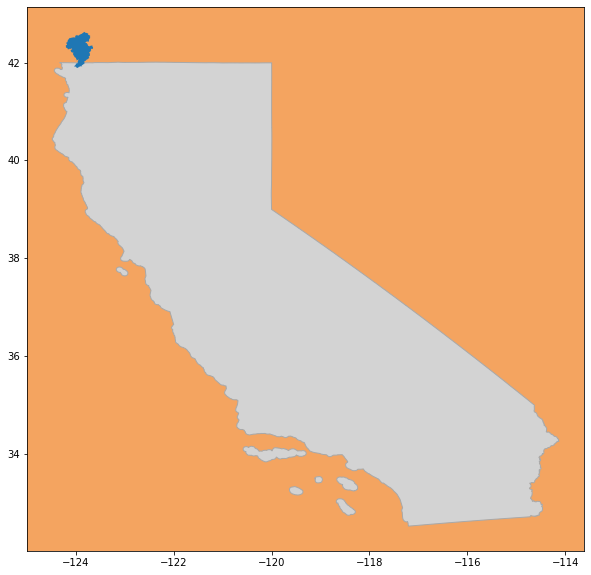

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
cal_fire_hist_df[cal_fire_hist_df.FIRE_NAME=='BISCUIT'].plot(ax=ax)
plt.show()

### Creating  a map for demo purposes

In [48]:
coverer_demo = s2.S2RegionCoverer()
coverer_demo.set_min_level(7)
coverer_demo.set_max_level(7)
# coverer.set_max_cells(500)
covering_demo = coverer_demo.GetCovering(loop)

In [49]:
len(covering_demo)

132

In [50]:
geoms_demo = []
for cellid in covering_demo:
    new_cell = s2.S2Cell(cellid)
    vertices = []
    for i in range(4):
        vertex = new_cell.GetVertex(i)
        latlng = s2.S2LatLng(vertex)
        vertices.append((latlng.lng().degrees(),
                         latlng.lat().degrees()))
    geo = Polygon(vertices)
    geoms_demo.append(geo)

In [51]:
len(geoms_demo)

132

In [52]:
geoms_demo_df = gpd.GeoDataFrame(crs=crs, geometry=geoms_demo)  
geoms_demo_df.shape

(132, 1)

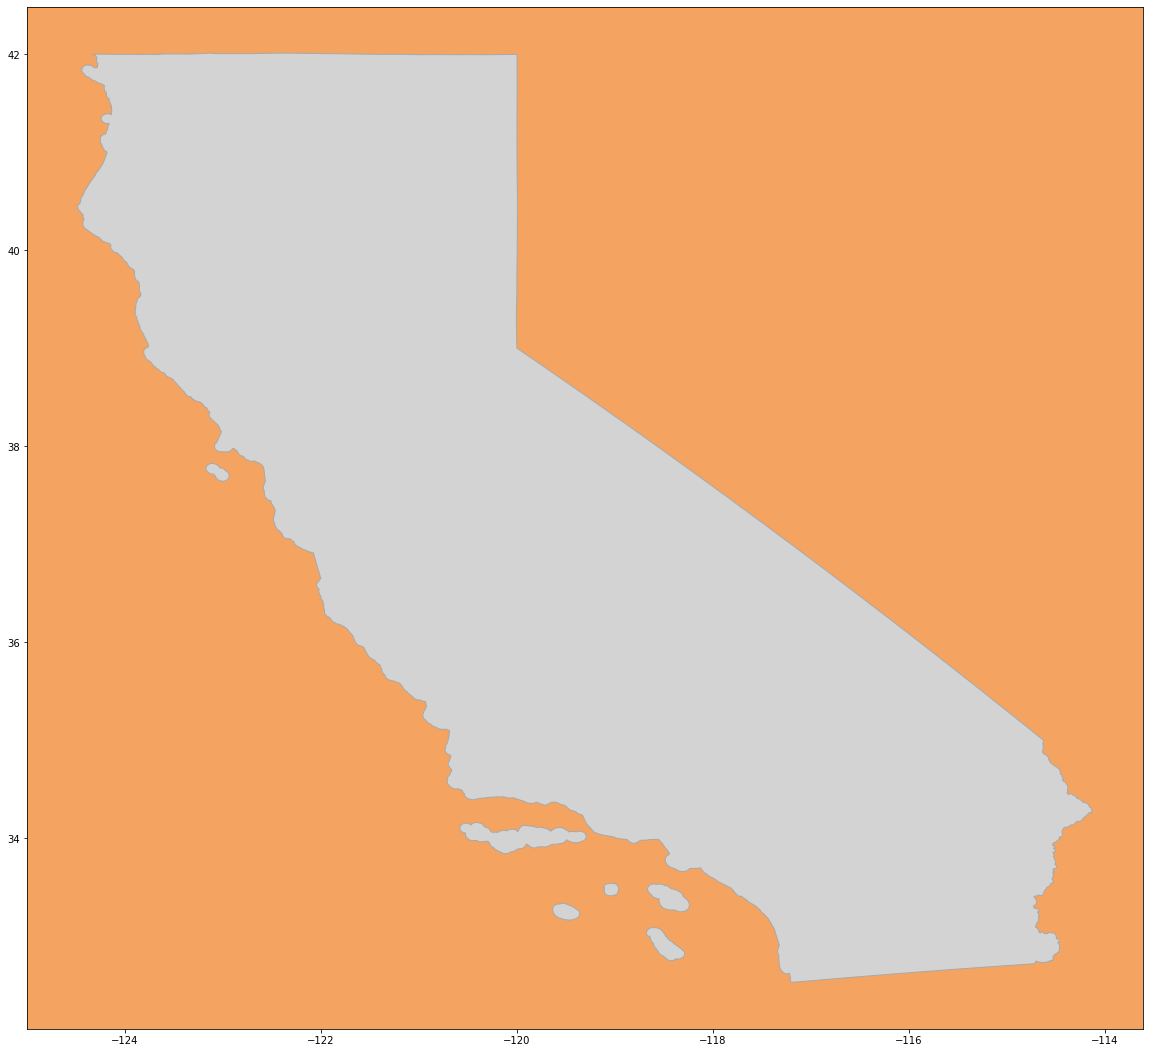

In [53]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
plt.show()

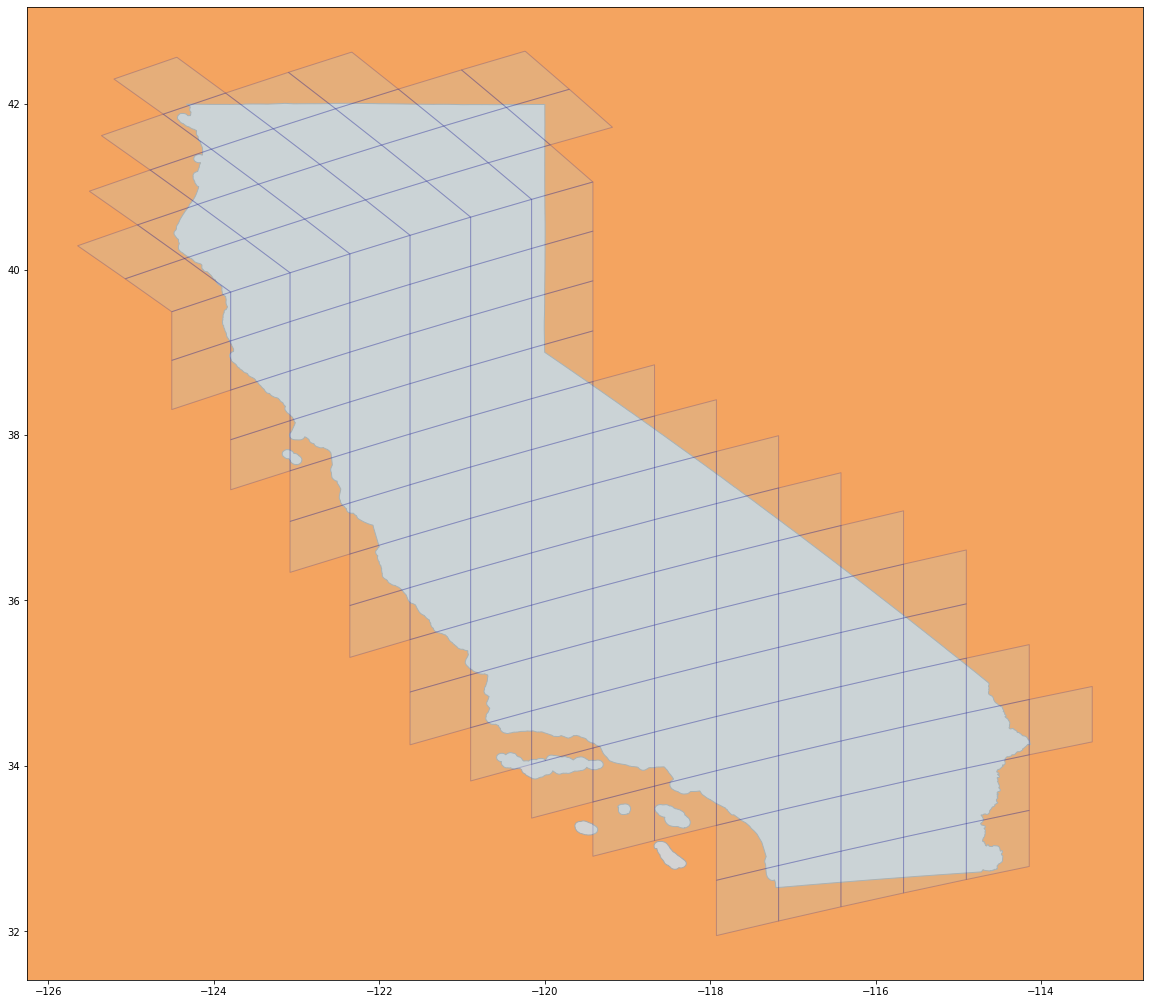

In [54]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
geoms_demo_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
plt.show()

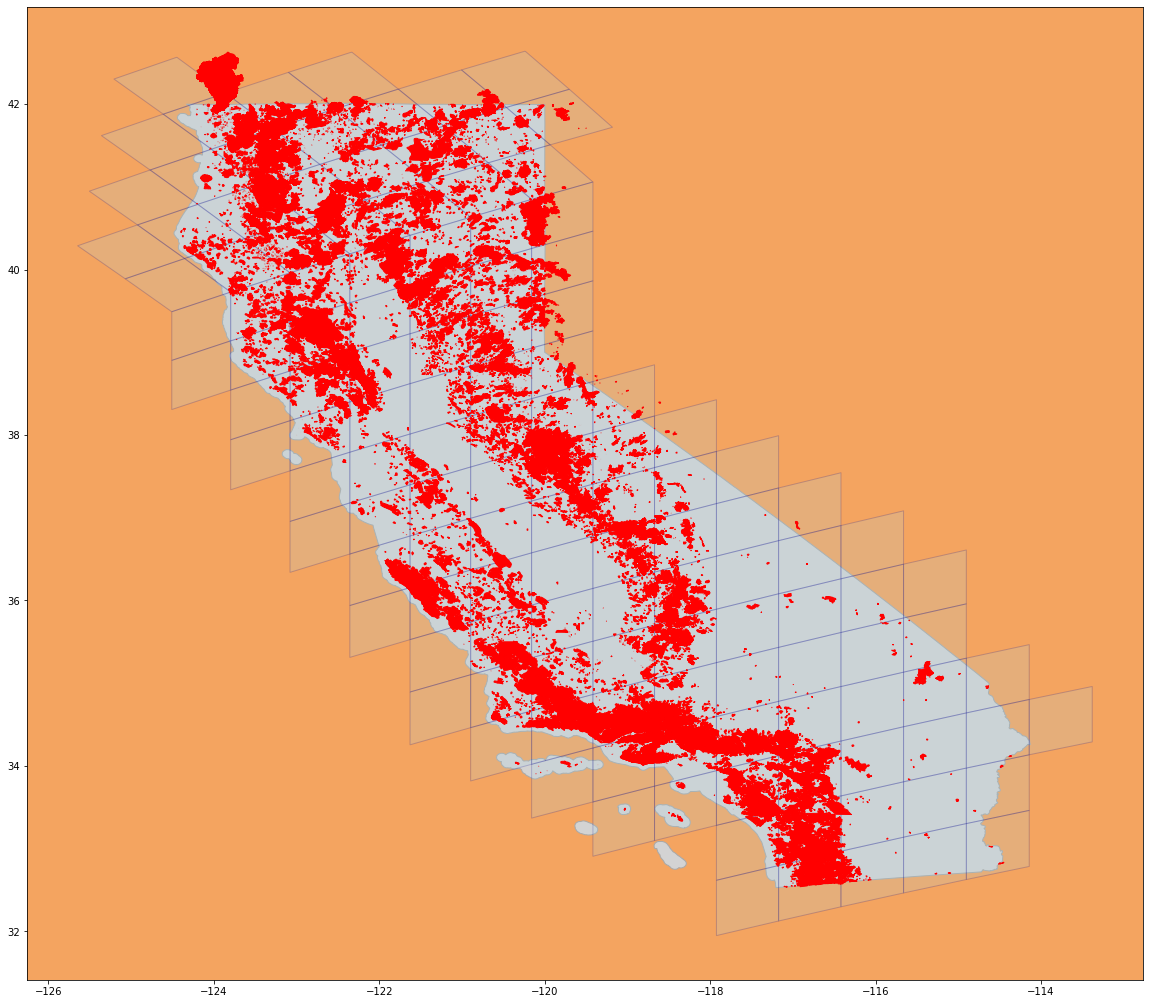

In [55]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
geoms_demo_df.plot(ax=ax, color='lightblue', edgecolor='darkblue', alpha=0.2)
cal_fire_hist_df.plot(ax=ax, color='red', edgecolor='red')
plt.show()

## WildFire EDA

### Historical Trends

In [68]:
cal_fire_hist_df[cal_fire_hist_df.GIS_ACRES>1].GIS_ACRES.describe()

count     20022.000000
mean       1777.759971
std        9827.434791
min           1.000042
25%          37.158121
50%         180.737190
75%         685.720276
max      501082.031250
Name: GIS_ACRES, dtype: float64

In [97]:
fires_count = cal_fire_hist_df[(cal_fire_hist_df.YEAR>=2000) & (cal_fire_hist_df.GIS_ACRES>1)].YEAR.value_counts()
fires_area = cal_fire_hist_df[(cal_fire_hist_df.YEAR>=2000) & (cal_fire_hist_df.GIS_ACRES>1)].groupby(['YEAR']).GIS_ACRES.mean()

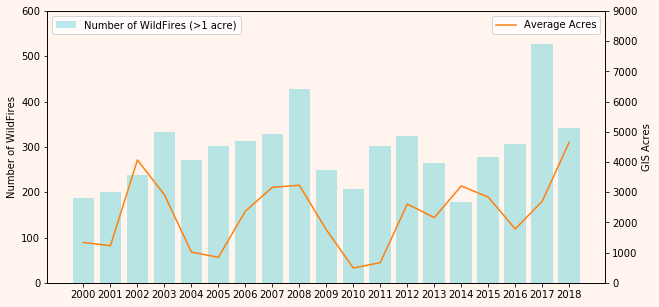

In [98]:
fig, ax1 = plt.subplots(figsize=(10,5))
fig.set_facecolor('seashell')
ax1.set_facecolor('seashell')
ax1.bar(fires_count.index, fires_count, color='tab:cyan', alpha=0.3, label='Number of WildFires (>1 acre)')
ax1.set_xticks(range(2000,2019))
ax1.set_ylim(0, 600)
ax1.set_ylabel('Number of WildFires')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(fires_area, color='tab:orange', label='Average Acres')
ax2.set_ylim(0, 9000)
ax2.set_ylabel('GIS Acres')
ax2.legend()
plt.show()

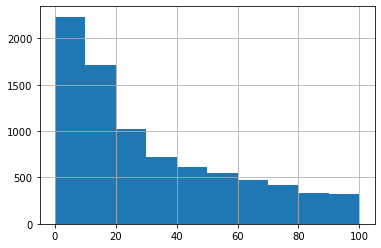

In [65]:
cal_fire_hist_df.GIS_ACRES[cal_fire_hist_df.GIS_ACRES<100].hist()

### Causes

In [81]:
cal_fire_hist_df.CAUSE.value_counts()

14.0    9293
9.0     3320
1.0     3310
2.0     1141
7.0      863
5.0      689
10.0     386
4.0      368
11.0     348
3.0      336
8.0      180
18.0      85
6.0       80
15.0      18
19.0      17
16.0      13
13.0      11
12.0       5
Name: CAUSE, dtype: int64

In [83]:
pl_fires = cal_fire_hist_df[cal_fire_hist_df.CAUSE == 11]
pl_fires.shape

(348, 19)

In [103]:
pl_fires_years = pl_fires[pl_fires.YEAR>=2000].YEAR.value_counts().sort_index()
pl_fires_years_acres = pl_fires[pl_fires.YEAR>=2000].groupby(['YEAR']).GIS_ACRES.mean()
pl_fires_years

2000.0     8
2001.0    11
2002.0    20
2003.0    12
2004.0    10
2005.0    13
2006.0    13
2007.0    16
2008.0    13
2009.0    12
2010.0     9
2011.0    16
2012.0    15
2013.0    14
2014.0     6
2015.0    10
2016.0     9
2017.0    31
2018.0    25
Name: YEAR, dtype: int64

In [104]:
pl_fires_years_acres

YEAR
2000.0     206.034644
2001.0      89.907160
2002.0    3799.481234
2003.0     232.467171
2004.0     321.957598
2005.0     382.036550
2006.0     570.116119
2007.0     429.658748
2008.0     165.024099
2009.0     636.262250
2010.0     436.685403
2011.0     161.740489
2012.0     901.455530
2013.0      66.134913
2014.0     167.906890
2015.0     312.686047
2016.0     114.060253
2017.0     460.706125
2018.0    6270.757281
Name: GIS_ACRES, dtype: float64

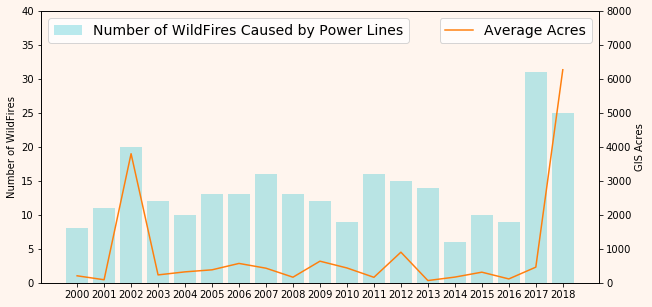

In [136]:
fig, ax1 = plt.subplots(figsize=(10,5))
fig.set_facecolor('seashell')
ax1.set_facecolor('seashell')
ax1.bar(pl_fires_years.index, pl_fires_years, color='tab:cyan', alpha=0.3, label='Number of WildFires Caused by Power Lines')
ax1.set_xticks(range(2000,2019))
ax1.set_ylim(0, 40)
ax1.set_ylabel('Number of WildFires')
ax1.legend(loc='upper left', fontsize=14)
ax2 = ax1.twinx()
ax2.plot(pl_fires_years_acres, color='tab:orange', label='Average Acres')
ax2.set_ylim(0, 8000)
ax2.set_ylabel('GIS Acres')
ax2.legend(loc='upper right', fontsize=14)
plt.show()

In [109]:
tl_df = gpd.read_file("./Data/Transmission_Line/Transmission_Line.shp")
tl_df.head()

,OBJECTID,Name,kV,kV_Sort,Owner,Status,Circuit,Type,Legend,Length_Mil,Length_Fee,Comments,Shape__Len,geometry
0,2001,PG&E 60kV,60,60.0,PG&E,Operational,Single,OH,PG&E_60_70kV,1.0,5813.64639807,None,0.018523,LINESTRING (-122.025217180817 39.7560586198882...
1,2002,PG&E 60kV,60,60.0,PG&E,Operational,Single,OH,PG&E_60_70kV,2.0,11459.33011218,None,0.032482,LINESTRING (-122.010209405169 39.5827809214517...
2,2003,PG&E 60kV,60,60.0,PG&E,Operational,Single,OH,PG&E_60_70kV,11.0,56984.89118592,None,0.159223,LINESTRING (-122.003238381708 39.5533528274813...
3,2004,PG&E 60kV,60,60.0,PG&E,Operational,Single,OH,PG&E_60_70kV,15.0,81003.57166241,None,0.250896,LINESTRING (-122.013588113745 39.4023799821862...
4,2005,PG&E 60kV,60,60.0,PG&E,Operational,Single,OH,PG&E_60_70kV,20.0,105641.41726686,None,0.300362,"LINESTRING (-122.153286201514 39.276960876995,..."


In [110]:
pl_fires.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,YEAR
41,2007,CA,CDF,LNU,SPRUCE,00004982,2007-07-15T00:00:00,2007-07-15T00:00:00,11.0,,NaN,129.011093,5.0,1.0,00000000,4042.514373,5.220894e+05,(POLYGON ((-122.5465874055749 38.8425074512519...,2007.0
55,2007,CA,CCO,ORC,ANTONIO,00000000,2007-06-25T00:00:00,None,11.0,,NaN,0.879536,NaN,1.0,07040974,238.572471,3.559355e+03,(POLYGON ((-117.6219677947194 33.5494566135543...,2007.0
59,2007,CA,CDF,RRU,ROCA,00091948,2007-10-21T00:00:00,2007-10-21T00:00:00,11.0,,256.0,270.026520,7.0,1.0,00000000,5652.827771,1.092759e+06,(POLYGON ((-116.8618380870892 33.4502222758832...,2007.0
61,2007,CA,CCO,SBC,MARIPOSA,00007295,2007-09-03T00:00:00,2007-09-04T00:00:00,11.0,,187.0,188.254623,7.0,1.0,00007295,4578.864001,7.618394e+05,(POLYGON ((-120.1803691097523 34.4776787020352...,2007.0
62,2007,CA,CCO,SBC,SEDGWICK,00008758,2007-10-21T00:00:00,2007-10-23T00:00:00,11.0,CA-LPF-001783,710.0,808.829224,7.0,1.0,00008758,8061.132352,3.273216e+06,"(POLYGON ((-120.014050888177 34.7271094207335,...",2007.0


In [117]:
pl_fires[pl_fires.YEAR==2002].sort_values(by='GIS_ACRES', ascending=False).head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,YEAR
14506,2002,CA,CDF,MVU,PINES,00005658,2002-07-29T00:00:00,2002-08-11T00:00:00,11.0,,61690.00,61691.238281,2.0,1.0,00000777,193363.898085,2.496556e+08,(POLYGON ((-116.4696770792027 33.3249233513629...,2002.0
10271,2002,CA,DOD,AFV,SUDDEN,00000364,2002-06-15T00:00:00,2002-06-15T00:00:00,11.0,,7502.14,7503.214844,1.0,1.0,00000364,49456.775746,3.036443e+07,(POLYGON ((-120.5609953701382 34.5822738521600...,2002.0
13609,2002,CA,CCO,ORC,GREEN,02008311,2002-02-09T00:00:00,2002-02-12T00:00:00,11.0,,2234.33,2234.359863,6.0,1.0,02008311,16551.638265,9.042134e+06,(POLYGON ((-117.6832056079794 33.8670383143271...,2002.0
11171,2002,CA,CDF,SCU,VIEUX,00002228,2002-06-18T00:00:00,2002-06-18T00:00:00,11.0,,1029.00,1028.645020,8.0,1.0,00000127,16655.848807,4.162779e+06,(POLYGON ((-121.5187547777358 37.7023748363806...,2002.0
13601,2002,CA,CDF,NEU,FIELD,00008324,2002-06-09T00:00:00,2002-06-13T00:00:00,11.0,,937.00,936.646484,7.0,1.0,00000302,12231.930375,3.790474e+06,(POLYGON ((-121.3225396347789 39.2419992824281...,2002.0


In [126]:
pl_fires[pl_fires.FIRE_NAME.isna()]

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geometry,YEAR
19012,2015,CA,LRA,ORC,None,,2015-07-03T00:00:00,2015-07-03T00:00:00,11.0,1900 LAGUNA CANYON RD NEAR DRIVEWAY/CANYON ACR...,NaN,14.130054,5.0,1.0,15065867,1144.694936,57182.302099,(POLYGON ((-117.7769039306588 33.5559681739321...,2015.0


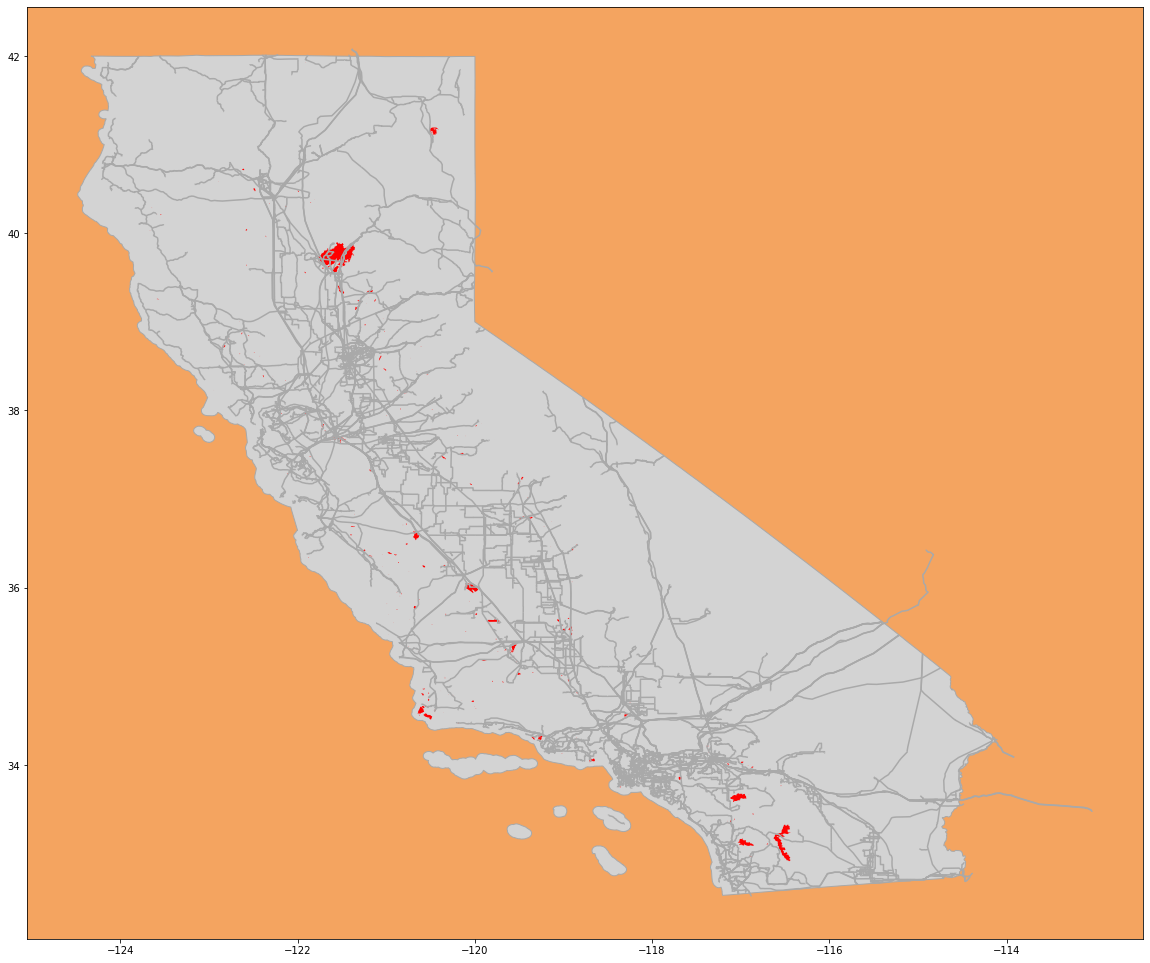

In [129]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_aspect('equal')
ax.set_facecolor('sandybrown')
ca_df.plot(ax=ax, color='lightgrey', edgecolor='darkgrey')
tl_df.plot(ax=ax, color='darkgrey')
# pl_fires[~pl_fires.FIRE_NAME.isna()].plot(ax=ax, column='FIRE_NAME', legend=True)
pl_fires.plot(ax=ax, color='red', legend=True)
# ax.set_axis_off()
plt.show()